# Introduction

The dataset being explored was provided by Microsoft to show how Azure could be used for an end-to-end machine learning platform, capable of building and deplying models. The data set consists of five tables:  
1. Machine Meta Data - associates a machine's ID number to its model type and age  
2. Error Log - log of when an error occured, the type of error that occurred, and the machine it occurred on. An error does not cause the machine to shut down.  
3. Failure Log - log of when a failure occured, and the machine it occurred on.  
4. Maintenance Log - log of when maintenanced was performed, and the machine it occurred on. Does not differntiate between if it was planned maintenance or unplanned maintenance.  
5. Telemetry Data - Hourly average machine sensor data for each machine. Data included is the machines voltage, rotation, pressure, and vibration.  

This data can be found through [Kaggle](https://www.kaggle.com/arnabbiswas1/microsoft-azure-predictive-maintenance) or through www.azuremlsampleexperiments.blob.core.windows.net/datasets  

The data was collected hourly for the entirety of 2015, so there are 8,736 rows of data for each machine. The goal for this data is to use it to be able to predict when a failure will occur at least 4 hours in advance, so it can be properly shut down and maintenance personnel can be dispatched.

# Import Data & Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os
import seaborn as sns
import datetime as dt

In [2]:
wd = os.getcwd()
base_path = wd.replace('notebooks', 'data')

# Machine Meta Data 
mach_meta = pd.read_csv(base_path + '\\PdM_machines.csv')

# Error Logs
err_log = pd.read_csv(base_path + '\\PdM_errors.csv')
err_log['datetime'] = pd.to_datetime(err_log['datetime'])

# Failure Logs
fail_log = pd.read_csv(base_path + '\\PdM_failures.csv')
fail_log['datetime'] = pd.to_datetime(fail_log['datetime'])

# Maintenance Logs
maint_log = pd.read_csv(base_path + '\\PdM_maint.csv')
maint_log['datetime'] = pd.to_datetime(maint_log['datetime'])

# Sensor Data
sens_data = pd.read_csv(base_path + '\\PdM_telemetry.csv')

# Exploratory Data Analysis

### Questions to Answer:  
1. Are there major differences in the machine models?  
2. Do older computers have more failures/ errors?  
3. Is there a trend in the failure/ error rates?  
4. Which computers experience the most/least failures? is it related to a certain model?  
5. What does the distibution of failures look like?  
6. Are all machines maintained at the same schedule if no failure occurs?  
7. Do certain errors result in failures more often?  
8. Are there any trends in the sensor data?  


Notes for self:  
fast way to calculate trends is correlation coefficient and R^2 value
Overlay when errors/ failures/ maintenance occurred on the trend data.
Divide total number of failures by the number of computers of that type - percentage


## Machine Data

In [3]:
mach_meta.describe(include='all')

,machineID,model,age
count,100.000000,100,100.000000
unique,NaN,4,NaN
top,NaN,model3,NaN
freq,NaN,35,NaN
mean,50.500000,NaN,11.330000
std,29.011492,NaN,5.856974
min,1.000000,NaN,0.000000
25%,25.750000,NaN,6.750000
50%,50.500000,NaN,12.000000
75%,75.250000,NaN,16.000000


There are 100 machines, 4 different models, and machine ages ranging from brand new to 20 years old. Let's look at the break down of the machine ages for each type of model.

         age                                                    
       count       mean       std  min    25%   50%    75%   max
model                                                           
model1  16.0  12.250000  5.385165  2.0   9.25  14.0  16.00  20.0
model2  17.0  12.764706  5.847322  2.0  10.00  14.0  18.00  20.0
model3  35.0  12.028571  5.607168  1.0   8.50  14.0  17.00  20.0
model4  32.0   9.343750  6.099230  0.0   4.00   9.5  14.25  20.0


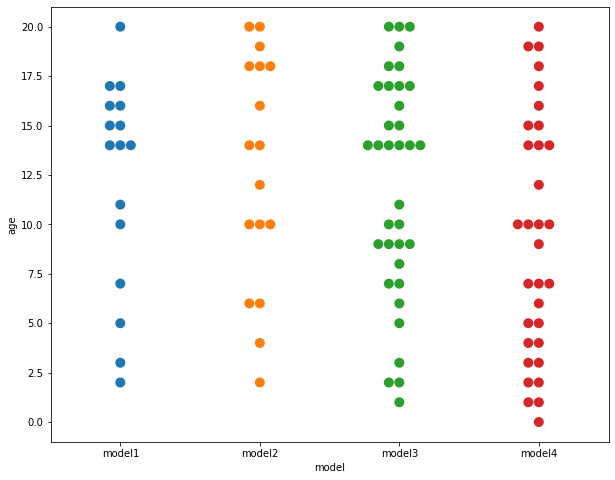

In [4]:
print(mach_meta[['model', 'age']].groupby('model').describe())

fig = plt.figure(figsize=(10,8))
sns.swarmplot(x='model', y='age', data=mach_meta, 
              order=['model1', 'model2', 'model3', 'model4'], size=10)
plt.show()

Although there are less models of type 1 and 2 the overall distributions of the four models are remarkably similar. Three of the models have a mean age of 12 and a standard deviation of 5.5. Model 4 is slightly different since the units are younger in general, mean age of 9, but the standard deviation is similar to the others.  

[1] So, for the most part, based on the meta data there is no major difference in the machine models.

## Failure & Maintenance Logs

Let's start by determining if more than one failure or maintenance event occurs within a given hour for a single computer. If so we will need to get a count before merging the two tables.

In [5]:
maint_log['maintenance'] = 1
maint_log.drop(columns=['comp'], inplace=True)


fail_log['failure'] = 1


#determine if more than one maintenance event occurs on a given day and machine
maint_log.groupby(['datetime', 'machineID']).sum().sort_values('maintenance', ascending=False).head(10)

maintenance
datetime            machineID             
2014-07-01 06:00:00 97                   3
2014-08-15 06:00:00 96                   3
2015-06-05 06:00:00 26                   2
2015-09-12 06:00:00 49                   2
2015-09-10 06:00:00 82                   2
2015-09-12 06:00:00 18                   2
                    44                   2
2015-04-02 06:00:00 4                    2
2015-04-01 06:00:00 65                   2
2015-04-02 06:00:00 81                   2

So a computer can be maintenance multiple times within a given hour for a computer so we need to get a count for each comptuer and datetime.

In [6]:
# combine the maintenance and failure log counts
maint_log_count = maint_log.groupby(['datetime', 'machineID']).sum()
fail_log_count = fail_log.groupby(['datetime', 'machineID']).sum()

issues_log = maint_log_count.merge(fail_log_count, how='outer', on=['datetime', 'machineID'])
issues_log.sort_index(inplace=True)
issues_log = issues_log.loc[dt.datetime.fromisoformat('2015-01-01'):]

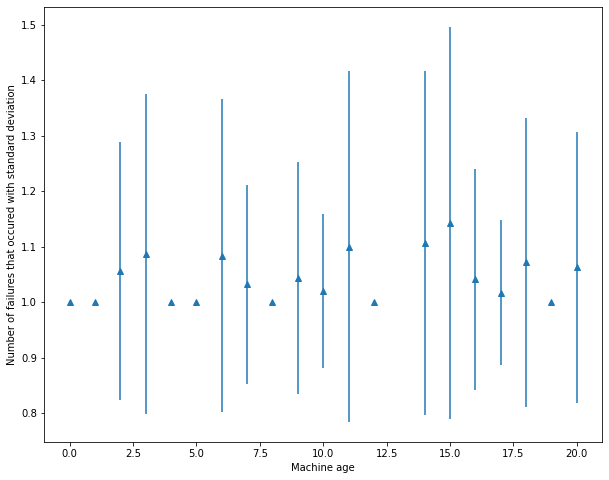

In [7]:
# Determine if the number of failures are correlated to age
age_issue_log = issues_log.merge(mach_meta, how='inner', on='machineID').groupby('age').agg({'failure':['mean','std']})

fig = plt.figure(figsize=(10,8))
plt.errorbar(age_issue_log.index, age_issue_log[('failure','mean')], age_issue_log[('failure','std')], linestyle='None', marker='^')
plt.xlabel('Machine age')
plt.ylabel('Number of failures that occured with standard deviation')

plt.show()

Additional number of errors experienced per year aged: 0.12565258486915912, and coefficient of determination: 0.01143426491317956


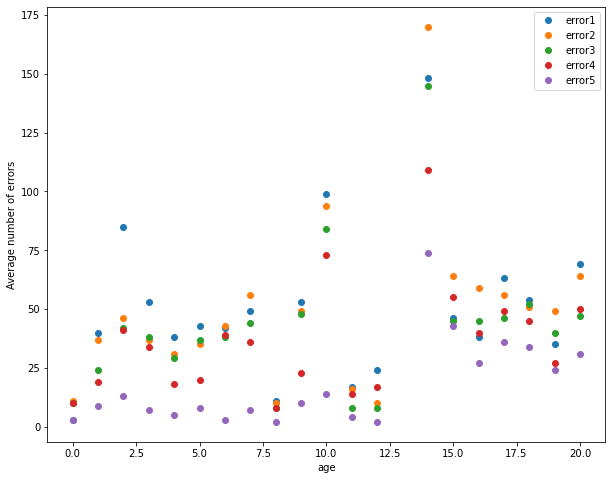

In [8]:
# Determine if there is a correlation between age and th number of errors expierienced
from sklearn.linear_model import LinearRegression
err_age_fit = err_log.groupby('machineID').count().merge(mach_meta, how='inner', on='machineID')
err_age_fit
lr = LinearRegression()
lr.fit(err_age_fit['age'].values.reshape([-1,1]), err_age_fit['errorID'])
print('Additional number of errors experienced per year aged: {}, and coefficient of determination: {}'.format(lr.coef_[0], lr.score(err_age_fit['age'].values.reshape([-1,1]), err_age_fit['errorID'])))

# Number of each error vs. Age
err_age_log = err_log.merge(mach_meta, how='inner', on='machineID').groupby(['errorID', 'age']).count()

#plot the number of errors that occurred for each error type at each age group
fig = plt.figure(figsize=(10,8))
err_age_log['model'].xs('error1').plot(label='error1', linestyle='', marker='o')
err_age_log['model'].xs('error2').plot(label='error2', linestyle='', marker='o')
err_age_log['model'].xs('error3').plot(label='error3', linestyle='', marker='o')
err_age_log['model'].xs('error4').plot(label='error4', linestyle='', marker='o')
err_age_log['model'].xs('error5').plot(label='error5', linestyle='', marker='o')

plt.legend()
plt.ylabel('Average number of errors')

plt.show()

[2] It does not look like older machines experience significantly more errors or failures than new machines.

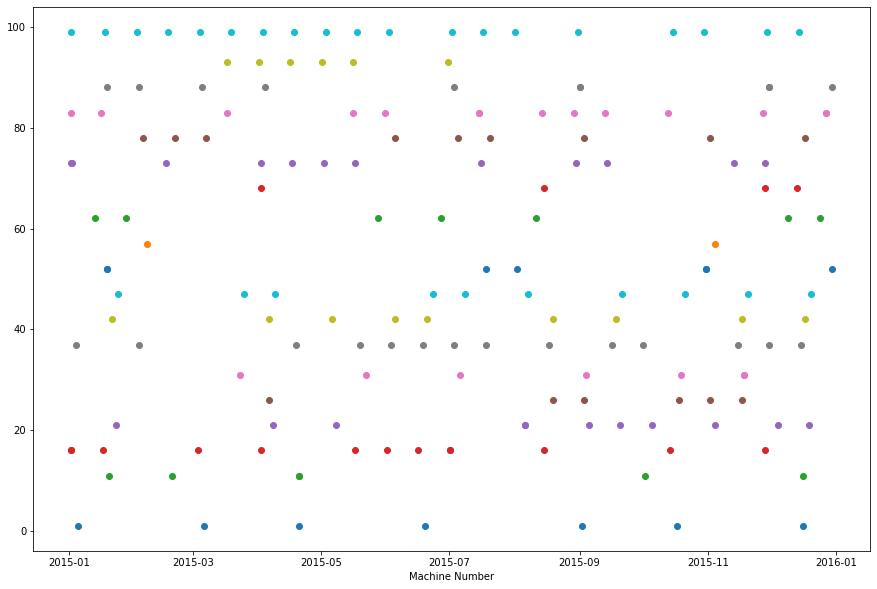

In [9]:
mach_list = np.linspace(1, 99, 20, dtype=int)

fig, ax = plt.subplots(figsize=(15,10), sharex=True)

for m in mach_list:
    mach = fail_log[fail_log['machineID'] == m]
    ax.plot(mach.datetime, m * mach.failure, marker='o', linestyle='', label=m)

plt.xlabel('Machine Number')

plt.show()

In [10]:
mach_99 = fail_log[fail_log['machineID'] == 99]
mach_99_fails = mach_99[mach_99['failure'] == 1]
mach_99_fails['datetime'].diff()

739                NaT
740   16 days 03:00:00
741   15 days 00:00:00
742   15 days 00:00:00
743   15 days 00:00:00
744   15 days 00:00:00
745   15 days 00:00:00
746   15 days 00:00:00
747   15 days 00:00:00
748   15 days 00:00:00
749   15 days 00:00:00
750   30 days 00:00:00
751   15 days 00:00:00
752   15 days 00:00:00
753   30 days 00:00:00
754   45 days 00:00:00
755   15 days 00:00:00
756   30 days 00:00:00
757   15 days 00:00:00
Name: datetime, dtype: timedelta64[ns]

[3] There does not seem to be a trend in the failure data, such that failures do not occur more often as time goes on nor are the fialures consistently spaced for every unit. However, machine 99 does seem to have a consistent amount of time between failures, of approximately 15 days. this machine may be best ot look at for trends in the sensor data to see if there are any repeating patterns.

In [11]:
fail_log[['machineID', 'failure']].groupby('machineID').count().sort_values('failure')

,failure
machineID,
72,2
57,2
46,2
29,2
100,3
...,...
37,14
22,15
17,15


[4] Some machines had as few as 2 failures, while one machine had up to 19 failures occur during the year.

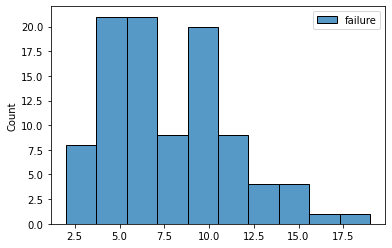

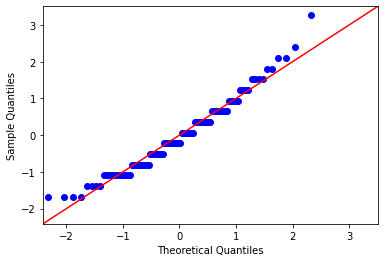

In [12]:
sns.histplot(fail_log[['machineID', 'failure']].groupby('machineID').count(), bins=10)

plt.show()

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import pylab as pl
from scipy.stats import norm, uniform

qqplot(fail_log[['machineID', 'failure']].groupby('machineID').count().sort_values('failure'), norm, fit=True, line='45')
pl.show()

[5] There are no outliers among the machines in regards to the number of failures they experienced. The failure rate for the most part of the machines seems to be normally distributed.

How do we determine if certain errors are associated with failures? If the error pops up before the failure occurs, or the error that occured the most and the number of failure, or the correlation between the number of each error type and the number of failures.

In [13]:
err_piv = pd.pivot_table(data=err_log, values='datetime', columns='errorID', index='machineID', aggfunc='count')
err_piv.fillna(0, inplace=True)

err_fail_corr = err_piv.merge(fail_log.groupby('machineID').agg({'failure':'count'}), how='inner', on='machineID')
err_fail_corr.corr()

,error1,error2,error3,error4,error5,failure
error1,1.000000,-0.150346,-0.020888,-0.106251,-0.240375,-0.038325
error2,-0.150346,1.000000,0.321146,0.025253,0.212545,0.183849
error3,-0.020888,0.321146,1.000000,-0.187219,0.090208,0.198517
error4,-0.106251,0.025253,-0.187219,1.000000,0.156952,0.299137
error5,-0.240375,0.212545,0.090208,0.156952,1.000000,0.503779
failure,-0.038325,0.183849,0.198517,0.299137,0.503779,1.000000


Although not definitive, we can see that the number of times a machine experienced error5 is relatively highly correlated to the number of failures the machine experienced. This error type might be a good indicator for predicting when a failure will occur. Lets try to plot when error5s occur and when failures occur for a machine

<ipython-input-14-b233ffbf02ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  err5['errorID'] = 1


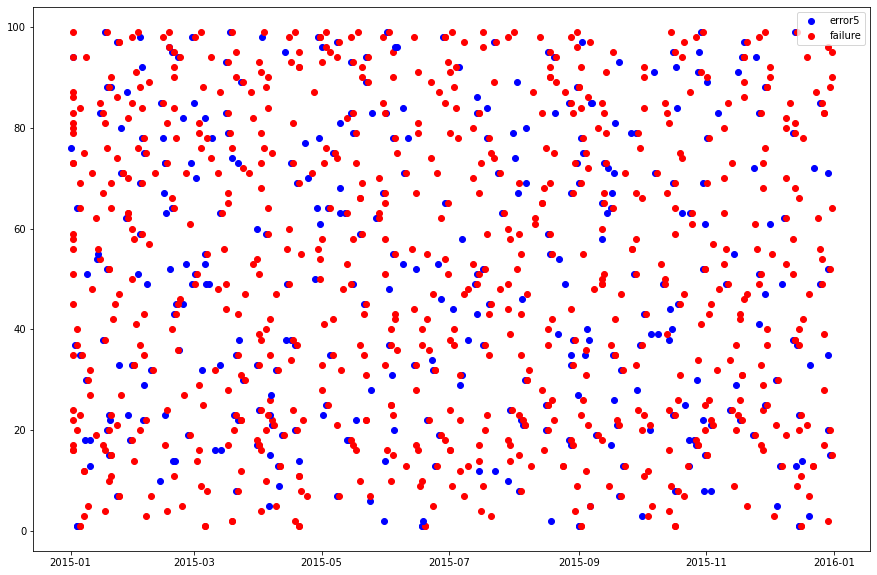

In [14]:
#err_log[err_log['errorID'] == 'error5'].merge(fail_log, how='outer', on=['machineID', 'datetime'])
err5 = err_log[err_log['errorID'] == 'error5']
err5['errorID'] = 1

fig = plt.figure(figsize=(15,10))
for m in np.linspace(1, 99, 100, dtype=int):
    plt.plot(err5[err5['machineID'] == m].datetime, m * err5[err5['machineID'] == m].errorID, marker='o', linestyle='', c='b')
    plt.plot(fail_log[fail_log['machineID'] == m].datetime, m * fail_log[fail_log['machineID'] == m].failure, marker='o', linestyle='', c='r')
    
plt.legend(['error5', 'failure'])

Based on the graph we can see that occasionally error type 5 occurs right before a failure occurs, but it is not consistent. [7] Therefore error 5 is associated with higher failure rates and often happens before a failure, but it is not gauranteed that if a machine encounters an error 5 that it will soon after experience a failure.

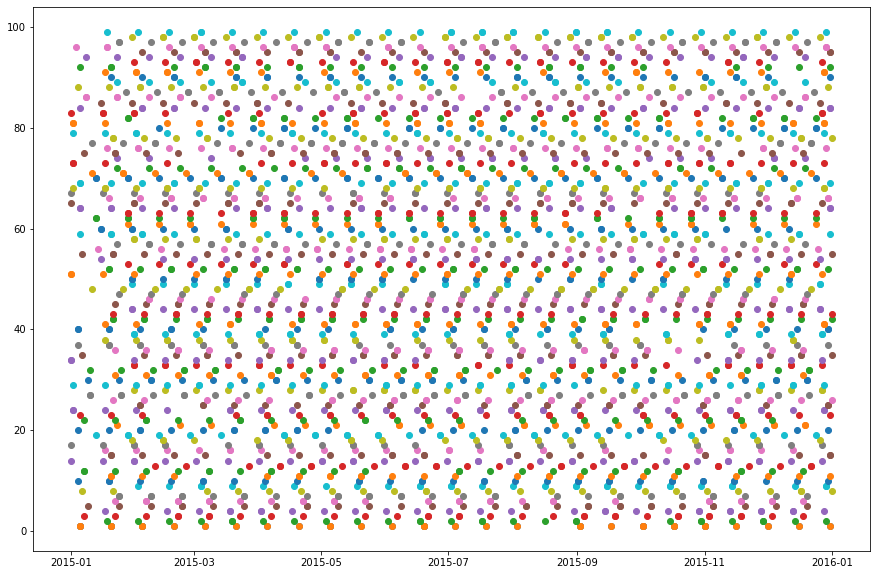

In [16]:
maint_log = maint_log[maint_log['datetime'] > dt.datetime.fromisoformat('2015-01-01')]

fig = plt.figure(figsize=(15,10))
for m in np.linspace(1, 99, 100, dtype=int):
    plt.plot(maint_log[maint_log['machineID'] == m].datetime, m * maint_log[maint_log['machineID'] == m].maintenance, marker='o', linestyle='')

[6] Based on the graph of the maintenance logs, it looks like the machines are maintenanced approximately every 15 days.

NOTE: get the time delta between maintenance events

## Sensor Data Exploration

In [ ]:
# Trends in sensor data
mach_99 = sens_data[sens_data['machineID'] == 99].sort_values('datetime')
mach_99.set_index('datetime', inplace=True)
mach_99.drop(columns=['machineID'], inplace=True)

mach_99.plot(figsize=(15,10))
plt.show()

In [ ]:
err_log